In [13]:
#load all necessary packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
%matplotlib inline

from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix

# Food-101
## NN Classification with Train Time Augmentation (TTA)

Using the Food-101 dataset from https://www.vision.ee.ethz.ch/datasets_extra/food-101/

Files and file structures all unchanged from the way compressed.

These 101,000 images across 101 classes are labeled and then split into a training set of 750 of each class and a test set of 250 images per class.  The images themselves are downloaded from foodspotting.com.
Below is a sample of the images in the set...


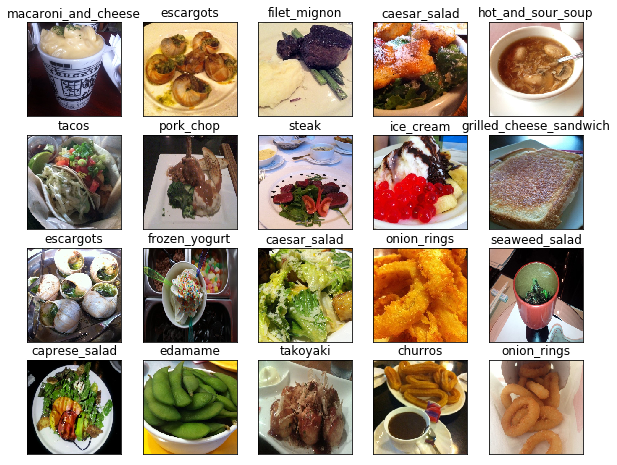

In [2]:
# Load and show a random sample of images from the dataset

from pathlib import Path
#get all image file names (w/ path)
all_images = [str(f) for f in Path('./food-101/images').glob('**/*.jpg')]

#set up plot space
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.2,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

## show sample pictures
for i in range(1, 21):
    ax = fig.add_subplot(4, 5, i,xticks=[],yticks=[])
    #choose andom images
    choice = np.random.choice(all_images)
    im = load_img(choice, target_size=(224,224))
    ax.set_title(choice.split('/')[2])
    ax.imshow(im)

In [3]:
#Set Dimension size for image resolution
img_height,img_width = 224, 224

#Define the base model
num_classes = 101
#load base InceptionV3 model, using imagenet weights as starting point
base_model = applications.inception_v3.InceptionV3(weights= 'imagenet', include_top=False, 
                                            input_shape= (img_height,img_width,3))

#add pooling and dropout to base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
#prediction layer
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

#compile model
opt = Adam() #optimizer choice
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Helper function to estimate memory usage of a NN model

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

batch_size=202
print('Estimated memory usage with image size', img_height, 'x', img_width, 'and batch size of', 
      batch_size, 'is:', get_model_memory_usage(batch_size, model), 'MB')

Estimated memory usage with image size 224 x 224 and batch size of 202 is: 12.677 MB


### Note: Memory was a big issue for me with this challenge.  CPU training was extremely slow, so I attempted to move to my GPU.  Switching from a Resnet50 model lto InceptionV3 represented significant memory savings..  however, to fit within my GPU memory with a minimum batch size of 101(number of classes), image size needed to be reduced to 120x120 which didn't prove to be enough for any decent training.  So, I went back to CPU training, with an increased image size and a batch size of 202.

In [5]:
#function to load image from filepath and return array
def load_image(img_path, dimensions, rescale=1. / 255):
    img = load_img(img_path, target_size=dimensions)
    x = img_to_array(img) #convert to array
    x *= rescale #rescale
    return x

In [6]:
#load provided train/test split files
train_files = pd.read_json('./food-101/meta/train.json')
test_files = pd.read_json('./food-101/meta/test.json')
#convert to flat lists
train_image_list = list(train_files.values.flatten())
test_image_list = list(test_files.values.flatten())
#train LableBinarizer for category encoding
lb = LabelBinarizer()
lb.fit(train_files.columns)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [7]:
#split training images into train and validation sets to avoid overfitting
train_size = int(len(train_image_list)*0.9)
train_list = train_image_list[:train_size]
val_list = train_image_list[train_size:]

In [8]:
#Generator function for image batches
def generate_image_arrays(im_list, batch):
    # needs to loop indefinitely
    i=0
    while True:
        # lists of images and labels
        images = []
        labels = []   
        # Loop until batch size filled
        while len(images) < batch:
            #get image array and label
            img = load_image("./food-101/images/" + im_list[i] + '.jpg', (img_height, img_width))
            label = im_list[i].split('/')[0]

            # update batch lists
            images.append(img)
            labels.append(label)
            i+=1
        
            #if at the end of the image list, reset counter to beginning, stop
            if i == len(im_list):
                i=0
                break
                
        # encode the labels using trained LB
        labels = lb.transform(np.array(labels))
        
        #return
        yield (np.array(images), labels)

In [11]:
#Train model
BS=202 #Batch size
#set early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#save best models along the way
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
NUM_EPOCHS = 20
train1 = model.fit_generator(generate_image_arrays(train_list, BS),
                            steps_per_epoch=len(train_list) // BS,
                             validation_data=generate_image_arrays(val_list, BS),
                             validation_steps=len(val_list) // BS,
                            epochs=NUM_EPOCHS, callbacks=[es, mc])

Epoch 1/20
337/337 [==============================] - 17481s 52s/step - loss: 0.5139 - acc: 0.8585 - val_loss: 2.9216 - val_acc: 0.4007

Epoch 00001: val_acc improved from -inf to 0.40072, saving model to best_model2.h5
Epoch 2/20
337/337 [==============================] - 17784s 53s/step - loss: 0.4367 - acc: 0.8794 - val_loss: 2.9822 - val_acc: 0.4234

Epoch 00002: val_acc improved from 0.40072 to 0.42344, saving model to best_model2.h5
Epoch 3/20
337/337 [==============================] - 20072s 60s/step - loss: 0.3670 - acc: 0.8974 - val_loss: 2.5453 - val_acc: 0.5062

Epoch 00003: val_acc improved from 0.42344 to 0.50617, saving model to best_model2.h5
Epoch 4/20
337/337 [==============================] - 17968s 53s/step - loss: 0.3259 - acc: 0.9099 - val_loss: 3.2196 - val_acc: 0.4755

Epoch 00004: val_acc did not improve from 0.50617
Epoch 5/20
337/337 [==============================] - 16938s 50s/step - loss: 0.2946 - acc: 0.9167 - val_loss: 3.8725 - val_acc: 0.4282

Epoch 0000

### For the rest of this notebook I will use a saved model which was trained for a total of 9 iterations and gave a training accuracy of ~90% and a test accuracy of just over 50%.

In [12]:
#load trained model
model = load_model('best_model2.h5')

### Predictions using TTA:

In [15]:
#Keras Generator for Image augmentation
image_gen = ImageDataGenerator(rescale = 1./255, #same as training
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.8, 1.2])

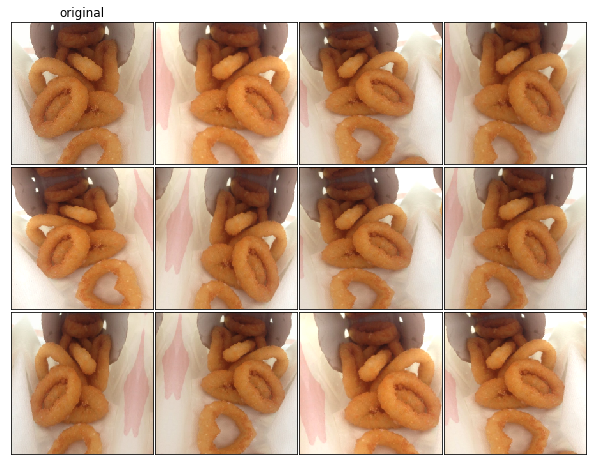

In [93]:
# View a sample of image augmentations
x = load_image(choice, (img_width,img_height))
## reshape (Sample, Nrow, Ncol, 3) 3 = R, G or B
x = x.reshape((1,) + x.shape)
#create plot space
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

## original picture
ax = fig.add_subplot(3, 4, 1,xticks=[],yticks=[]) 
im = load_img(choice, target_size=(img_height,img_width))
ax.imshow(im)
ax.set_title("original")

#augmentations
i=2
for aug in image_gen.flow(x, batch_size=8):
    new_x = aug.reshape(img_to_array(im).shape)
    ax = fig.add_subplot(3, 4, i,xticks=[],yticks=[])
    ax.imshow(array_to_img(new_x))
    i+=1
    if i>12:
        break

In [87]:
# function to make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, im_array, n_examples, beta = 0.3):
    # convert image into dataset
    samples = np.expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    #predict original image
    pred_orig = model.predict(np.expand_dims(im_array,axis=0))
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)
    # sum across augmented predictions
    summed = np.sum(yhats, axis=0)
    #combine original with augmentation using Beta as weighting
    summed = beta*pred_orig + (1-beta)*summed
    # argmax across classes to return top 1 for orig and with aug.
    return np.argmax(pred_orig), np.argmax(summed)

In [88]:
#Make predictions
from tqdm import tqdm_notebook as tqdm #progress bar

#convert label names to numeric
labels_numeric = [np.argmax(lb.transform([x.split('/')[0]])) for x in test_image_list]

NUM_AUG = 8 #number of augmentations

test_preds_orig = []#initialize prediction list (original images)
test_preds_aug = [] #initialize prediction list (with augmentations)
for i in tqdm(range(len(test_image_list))):
    #load test image
    test_im = load_img('./food-101/images/' + test_image_list[i] + '.jpg', target_size=(img_height,img_width))
    test_im_array = load_image('./food-101/images/' + test_image_list[i] + '.jpg', (img_height,img_width))
    #predict with augmentations
    pred_orig, pred_aug = tta_prediction(image_gen, model, test_im, test_im_array, NUM_AUG, 0.25)
    test_preds_orig.append(pred_orig) #add to list
    test_preds_aug.append(pred_aug) #add to list

HBox(children=(IntProgress(value=0, max=25250), HTML(value='')))

In [90]:
#Top 1 accuracy numbers
acc_orig = accuracy_score(labels_numeric, test_preds_orig)
print('Overall test accuracy Original only: %2.2f percent' % (round(acc_orig*100,2)))
acc_aug = accuracy_score(labels_numeric, test_preds_aug)
print('Overall test accuracy with Augmentations: %2.2f percent' % (round(acc_aug*100,2)))

Overall test accuracy Original only: 56.29 percent
Overall test accuracy with Augmentations: 59.79 percent


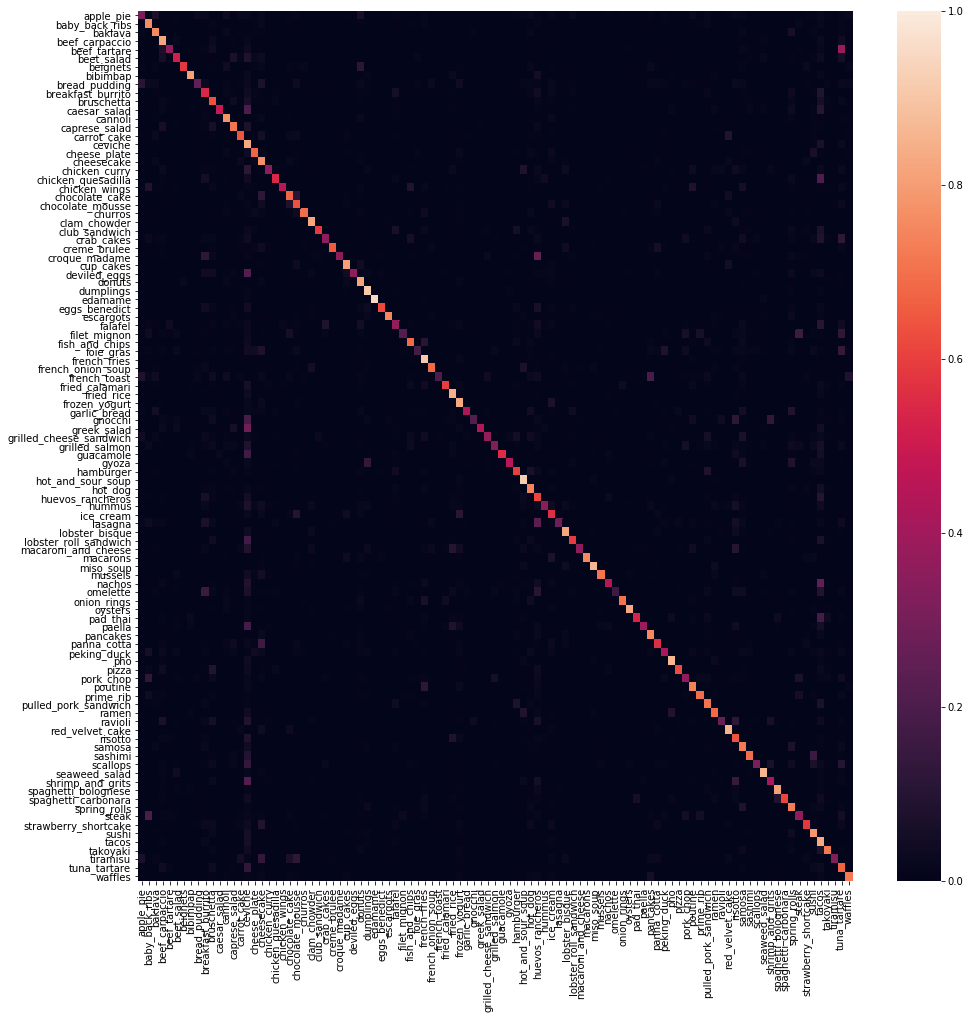

In [91]:
#Look at a heatmap of predictions
plt.figure(figsize=(16, 16))
text_labels = lb.inverse_transform(np.diag(np.ones(101)))
conf_mat = confusion_matrix(labels_numeric, test_preds_aug)/250.
sns.heatmap(conf_mat, vmin=0, vmax=1,
            xticklabels=text_labels, yticklabels=text_labels)

In [92]:
#Compute Top 5 and Bottom 5 prediction categories
results_df = pd.DataFrame(zip(text_labels, np.diag(conf_mat)), 
                          columns=['Image_Category', 'Accuracy']).sort_values('Accuracy', ascending=False)
#Top 5
display(results_df.head())
#Bottom 5
display(results_df.tail())

,Image_Category,Accuracy
33,edamame,0.952
54,hot_and_sour_soup,0.920
32,dumplings,0.908
40,french_fries,0.908
75,pho,0.864


,Image_Category,Accuracy
47,gnocchi,0.216
37,filet_mignon,0.208
42,french_toast,0.200
39,foie_gras,0.176
67,omelette,0.160


###  Obviously I fell quite a bit short of Sota here at around 60%...  though the TTA did gain about 3.5%.
### I do think this notebook would be easily scalable to increase image sizes, or add augmentations to training and/or validation runs.  I could also have retrained using all of the data without a validation set after determining a reasonable number of epochs...